In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.1/122.1 kB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 121.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 131.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 121.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 131.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 113.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=eaf3ead87eb222d55

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.1 MB/s eta 0:00:00a 0:00:01


# Analysis of clusters in sample S3

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


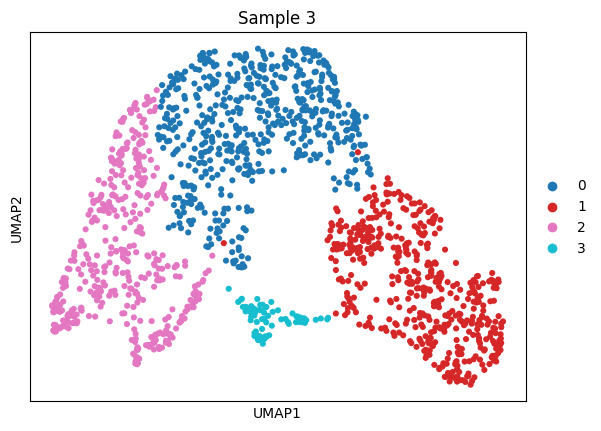

In [5]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Initial DE testing: Wilcoxon rank-sum for every cluster against all others

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


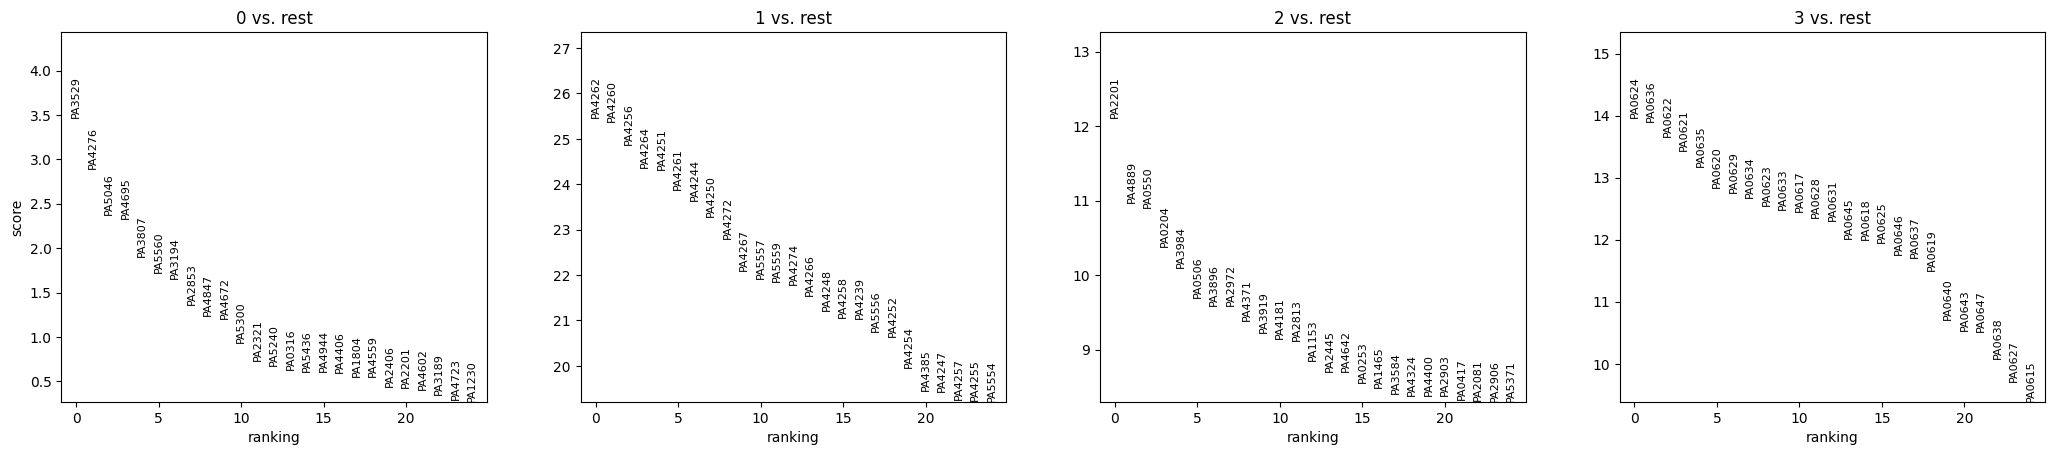

In [6]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [7]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 100
Both

Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 1000
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB an

Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 1900
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB an

Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log

Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 4100
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 4200
Both NB and ZINB log-likelihood nan! Using NB without starting params


Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 5200
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB an

## Find optimal correlation matrix scaling and generate synthetic null data

In [8]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

Factor: 1 - Error: 329.4443087362671
Factor: 2 - Error: 349.54714316344007
Factor: -0.618034 - Error: 432.53825894511056
Factor: 1 - Error: 329.4443087362671
Factor: 0.38196600897566 - Error: 424.7162316173394
Factor: 1.38196601 - Error: 316.7715319342563
Factor: 1.6180339872046798 - Error: 337.37041985461093
Factor: 1.2360679772046799 - Error: 309.0617282434733
Factor: 1.1458980338630373 - Error: 316.82780385730416
Factor: 1.2917960666583574 - Error: 312.0509543324683
Factor: 1.2016261237245467 - Error: 318.59795351601684
Factor: 1.2573542131782243 - Error: 311.2853593907057
Factor: 1.2229123598538687 - Error: 319.53733853214055
Factor: 1.244198595827413 - Error: 309.8554293943337
Factor: 1.2310429785361037 - Error: 308.333832434505
Factor: 1.2279373585592188 - Error: 308.6784044196233
Factor: 1.232962357227795 - Error: 308.33011311605486
Factor: 1.234148598498942 - Error: 308.8343145955268
Factor: 1.2322292198072506 - Error: 308.57950044613654
Factor: 1.2334154610730323 - Error: 309.

In [9]:
# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)

data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False)

In [10]:
data_null_gen.var_names = data_gene.var_names
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

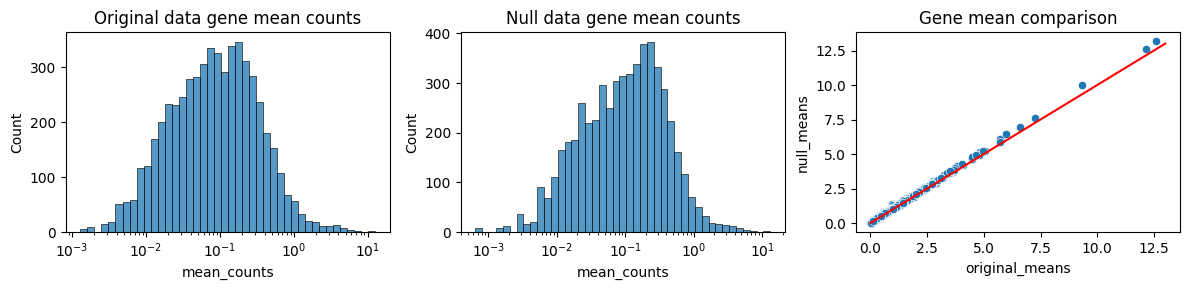

SignificanceResult(statistic=0.9956331663329897, pvalue=0.0)


In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

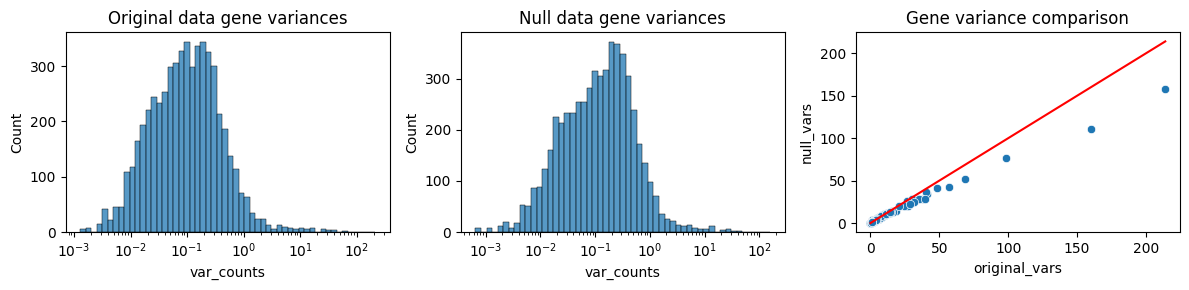

SignificanceResult(statistic=0.9923734364616457, pvalue=0.0)
[[1.       0.995984]
 [0.995984 1.      ]]


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

# g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

### Process null data

In [13]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [14]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="statsmod_auto")

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["est_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


gene 0
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 100
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 200
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting pa

Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 1500
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 1600
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params


gene 3200
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 3300
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 3400
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starti

Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 5000
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params
gene 5100
Both NB and ZINB log-likelihood nan! Using NB without starting params
Both NB and ZINB log-likelihood nan! Using NB without starting params


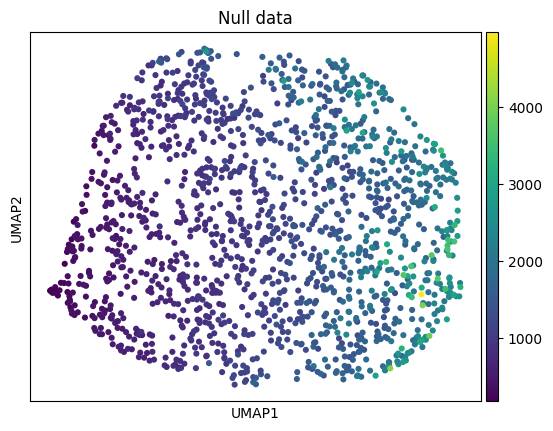

In [15]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [16]:
res2 = 0.01
twoclust = False

while twoclust is False:
    if (res2 * 100)%5 == 0:
        print(res2)
    res2 += 0.005
    res2 = np.round(res2, 3)
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=1234)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

0.05
Resolution for two clusters: 0.1


In [21]:
data_null_gen.write("../../data/MOBA_scRNAseq/outs_S3/S3_null_data_opt.h5ad")


In [17]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()

In [18]:
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.6684948202315661
Cluster 1 - DE genes: 54; Minimum q value: 0.02564102564102564
Cluster 2 - DE genes: 47; Minimum q value: 0.02564102564102564
Cluster 3 - DE genes: 0; Minimum q value: 0.15384615384615385


In [19]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.08333333333333333
Cluster 1 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 2902; Minimum q value: 0.03225806451612903
Cluster 3 - DE genes: 0; Minimum q value: 1.0


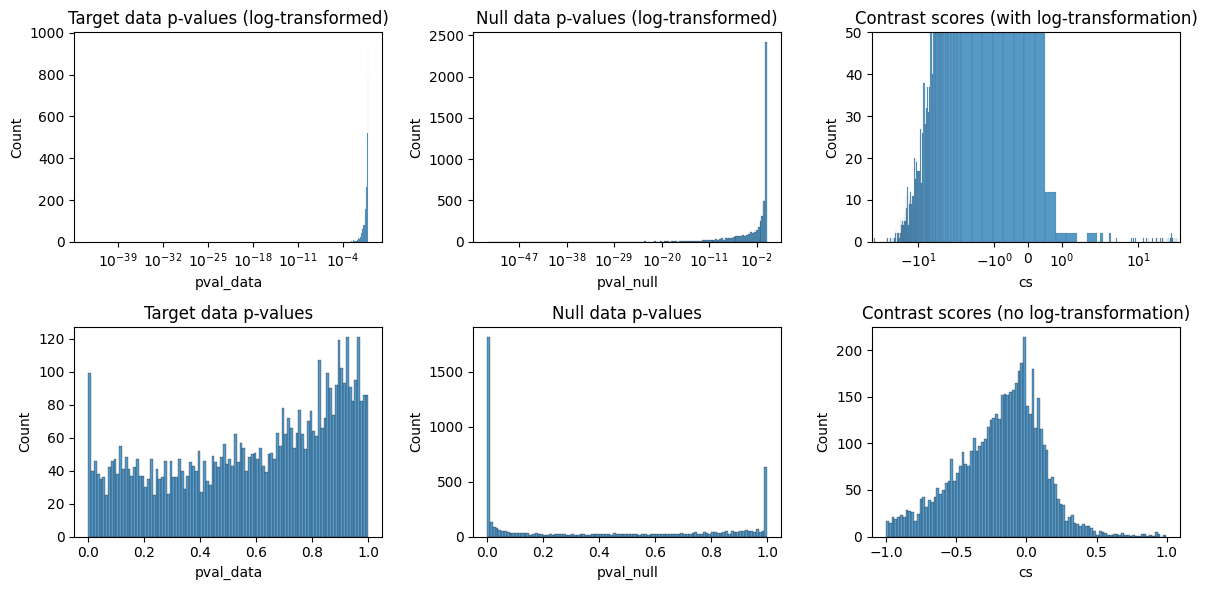

In [20]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()